# Khanh Truong - Coline Merlen (Web Mining | March 2019)

In [336]:
%matplotlib inline
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

import os
from sklearn.model_selection import train_test_split
from datetime import datetime

# Graph Approach

In [2]:
g = nx.read_adjlist('fake-news-prediction-toulouse/data_competition/UserUser.txt')

In [3]:
print('Number of nodes: {}'.format(len(g.node)))
print('Number of edges: {}'.format(len(g.edges)))

Number of nodes: 23865
Number of edges: 408824


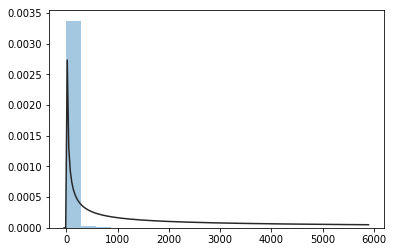

In [4]:
deg = nx.degree(g)
df = pd.Series([y for (x,y) in deg])
sns.distplot(df, bins=20, kde=False, fit=stats.powerlaw)
plt.show()

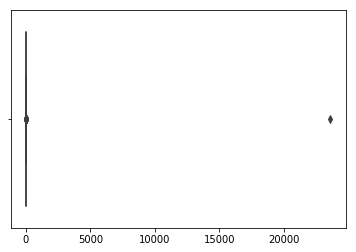

In [5]:
cc = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]
sns.boxplot(cc)
plt.show()

In [6]:
largest_cc = max(nx.connected_component_subgraphs(g), key=len)

### Prediction

In [236]:
# Import label data
label = pd.read_csv('fake-news-prediction-toulouse/data_competition/labels_training.txt', sep=',')
label.columns = ['news', 'fake']
label.head()

,news,fake
0,1,0
1,3,0
2,5,0
3,6,0
4,8,0


In [237]:
# Split into train and test sets
train, test = train_test_split(label, test_size=0.2, random_state=1234)

print('% fake in whole set: {}'.format(label.fake.mean()))
print('% fake in train set: {}'.format(train.fake.mean()))

% fake in whole set: 0.5025906735751295
% fake in train set: 0.4935064935064935


In [242]:
# Import news user data
news_user = pd.read_csv('fake-news-prediction-toulouse/data_competition/newsUser.txt', sep='\t', header=None)
news_user.columns = ['news', 'user', 'time']

# Merge label to news user
news_user_label = news_user.merge(train, left_on='news', right_on='news', how='left', copy=False)
news_user_label = news_user_label[~news_user_label.fake.isnull()] # not NA in column fake (have label)
news_user_label['fake_count'] = news_user_label['fake']*news_user_label['time'] # fake scaled by the times of posting
news_user_label.head()

,news,user,time,fake,fake_count
0,240,1,1,1.0,1.0
2,162,3,1,1.0,1.0
3,233,4,1,1.0,1.0
4,50,5,1,0.0,0.0
6,227,7,1,1.0,1.0


In [301]:
# Calculate percentage fake news posted by each user
user_fake_percent = news_user_label.groupby('user').agg({'time':'sum', # for each user, calculate total posting
                                                         'fake_count':'sum'}) # calculate total fake
user_fake_percent.columns = ['news_count','fake_count']
user_fake_percent['fake_percent'] = user_fake_percent['fake_count']/user_fake_percent['news_count'] # percentage of fake
user_fake_percent.sort_values(['fake_percent','news_count'], ascending=False, inplace=True) # sort value
user_fake_percent.head()

,news_count,fake_count,fake_percent
user,,,
19924,67,67.0,1.0
13973,45,45.0,1.0
8040,41,41.0,1.0
9584,40,40.0,1.0
4715,35,35.0,1.0


In [322]:
start = datetime.now()

degree= nx.degree_centrality(g)
closeness = nx.closeness_centrality(g)
eigenvector = nx.eigenvector_centrality_numpy(g)
katz = nx.katz_centrality_numpy(g)
betweenness = nx.betweenness_centrality(g)

end = datetime.now() 
str(end-start)

In [ ]:
degree_df = pd.DataFrame.from_dict(degree, orient='index')
closeness_df = pd.DataFrame.from_dict(closeness, orient='index')
eigenvector_df = pd.DataFrame.from_dict(eigenvector, orient='index')
katz_df = pd.DataFrame.from_dict(katz, orient='index')
betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index')

In [308]:
centrality_df = pd.concat()
centrality_df.columns = ['degree' ,'closeness', 'eigenvector', 'katz', 'betweenness']
centrality_df.index = centrality_df.index.astype(int)
centrality_df.index.name = 'user'
centrality_df.head()

,degree
user,
507,0.000461
1,0.000335
1589,0.009261
5307,0.000796
11421,0.004903


In [310]:
a = user_fake_percent.merge(degree_df, left_index=True, right_index=True, how='left')
a.head()

,news_count,fake_count,fake_percent,degree
user,,,,
19924,67,67.0,1.0,0.002598
13973,45,45.0,1.0,0.000419
8040,41,41.0,1.0,0.002682
9584,40,40.0,1.0,0.003185
4715,35,35.0,1.0,0.000126


In [332]:
np.log(1)

0.0

C:\Users\truong_ph\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


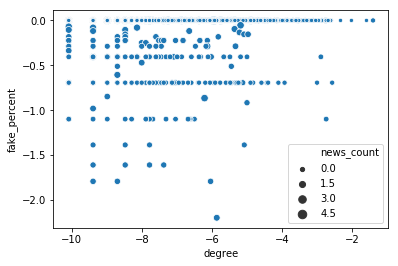

In [335]:
sns.scatterplot(
                x=np.log(a.degree),
                y=np.log(a.fake_percent),
                size=np.log(a.news_count));

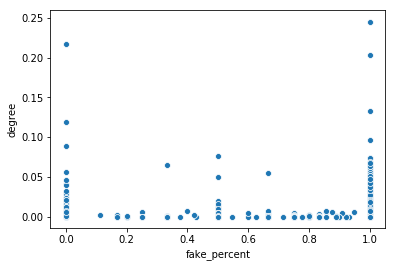

In [316]:
sns.scatterplot(data=a,
                x='fake_percent',
                y='degree');

In [268]:
user_fake_percent.shape

(16727, 3)

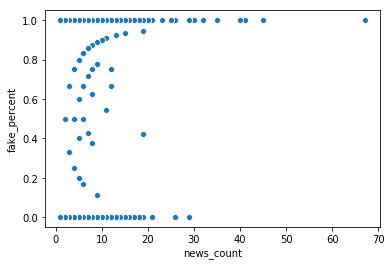

In [264]:
sns.scatterplot(data=user_fake_percent, x='news_count', y='fake_percent');

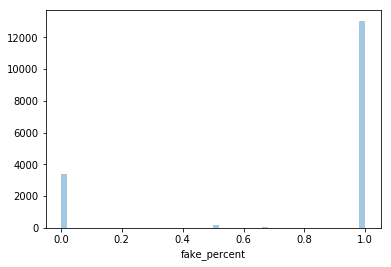

In [267]:
sns.distplot(user_fake_percent['fake_percent'], kde=False);

In [255]:
# Define fake_source, which are users who always post fake news
fake_source = user_fake_percent[user_fake_percent['fake_percent']==1].index
fake_source

Int64Index([19924, 13973,  8040,  9584,  4715,  8170,  8378, 12526, 18542,
            19590,
            ...
            23852, 23853, 23854, 23855, 23857, 23858, 23860, 23861, 23864,
            23865],
           dtype='int64', name='user', length=13040)

### Predict on test set

In [175]:
test.head()

,news,user,time,fake
5,155,6,1,NaN
12,178,10,1,NaN
13,178,11,1,NaN
16,128,14,1,NaN
17,145,14,1,NaN


In [180]:
# Define the news is fake if it's posted by a fake_source
test.loc[test.user.isin(fake_source), 'fake'] = 1
test['fake'].fillna(0, inplace=True) # otherwise
test.head()

,news,user,time,fake
5,155,6,1,0.0
12,178,10,1,1.0
13,178,11,1,0.0
16,128,14,1,1.0
17,145,14,1,1.0


In [194]:
# News is posted by many users
test['fake_time'] = test['fake']*test['time']
test_news = test.groupby('news').agg({'time':'sum',
                                      'fake_time':'sum'})
test_news.columns = ['post_count', 'fake_count']
test_news['fake_score'] = test_news['fake_count']/test_news['post_count']
test_news.sort_values(['fake_score', 'post_count'], ascending=False, inplace=True)
test_news.head()

,post_count,fake_count,fake_score
news,,,
183,1,1.0,1.000000
133,30,24.0,0.800000
125,38,30.0,0.789474
228,9,6.0,0.666667
206,131,85.0,0.648855


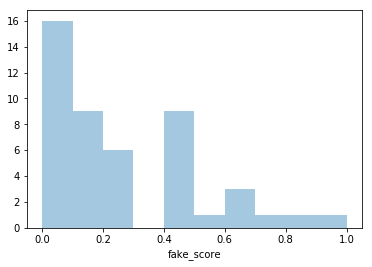

In [184]:
sns.distplot(test_news['fake_score'], kde=False, bins=10)
plt.show()

In [201]:
submit = test_news.copy()
submit['fake'] = 0

In [202]:
submit.loc[submit.fake_score>0.5, 'fake'] = 1

In [211]:
submit[['fake']].reset_index().sort_values('news').to_csv('version1.csv', sep=',', index=False)

In [214]:
0.3*47*0.71428

10.071348

In [212]:
0.71428*47

33.57116

In [65]:
test  = os.listdir('fake-news-prediction-toulouse/data_competition/news/test/')
len(test)

47